## ResNet Model

In [17]:
import torch
from torch import nn
from torch.optim import SGD, Adam
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split

from typing import Tuple, Union, List, Callable
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [34]:
# From Transfer Learning Tutorial
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])
    dataset = torchvision.datasets.ImageFolder('/kaggle/input/birds23sp/birds/train', transform=transform_train)
    final_test_dataset = torchvision.datasets.ImageFolder('/kaggle/input/birds23sp/birds/test', transform=transform_test)
    print([int(0.6 * len(dataset)), int( 0.1 * len(dataset)), int( 0.3 * len(dataset))])
    print(len(dataset))
    train_dataset, val_dataset, test_dataset = random_split(dataset, [int(0.6 * len(dataset)), int( 0.1 * len(dataset)), int( 0.3 * len(dataset) + 1)])
    
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=2)
    
    train_sub_dataset = torch.utils.data.Subset(train_dataset, range(4500))
    train_dataset_search, val_dataset_search = random_split(train_sub_dataset, [int(0.9 * len(train_sub_dataset)), int( 0.1 * len(train_sub_dataset))])

    # Create separate dataloaders for the train, test, and validation set
    train_loader_search = DataLoader(
        train_dataset_search,
        batch_size=128,
        shuffle=True
    )

    val_loader_search = DataLoader(
        val_dataset_search,
        batch_size=128,
        shuffle=True
    )

    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
    
    finaltestloader = torch.utils.data.DataLoader(final_test_dataset, batch_size=1, shuffle=False, num_workers=2)
    classes = open('/kaggle/input/birds23sp/birds/names.txt').read().strip().split("\n")
    class_to_idx = dataset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    print(len(idx_to_class))
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'val': valloader, 'test': testloader, 'final_test': finaltestloader, 'train_search': train_loader_search, 'val_search': val_loader_search, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

[23137, 3856, 11568]
38562
555


In [7]:
data['train']

In [19]:
# Train function modeled from CSE 446 PyTorch tutorial
batch_size = 128
def train(
    model: nn.Module, optimizer: SGD,
    train_loader: DataLoader, val_loader: DataLoader,
    epochs: int = 20
)-> Tuple[List[float], List[float], List[float], List[float]]:
    
    model.to(device)
    optimizer = SGD(model.parameters(), 0.1, 0.9)

    loss = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for e in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for (x_batch, labels) in train_loader:
            x_batch, labels = x_batch.to(device), labels.to(device)
            optimizer.zero_grad()
            labels_pred = model(x_batch)
            batch_loss = loss(labels_pred, labels)
            train_loss = train_loss + batch_loss.item()

            labels_pred_max = torch.argmax(labels_pred, 1)
            batch_acc = torch.sum(labels_pred_max == labels)
            train_acc = train_acc + batch_acc.item()

            batch_loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc / (batch_size * len(train_loader)))

        # Validation loop; use .no_grad() context manager to save memory.
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for (v_batch, labels) in val_loader:
                v_batch, labels = v_batch.to(device), labels.to(device)
                labels_pred = model(v_batch)
                v_batch_loss = loss(labels_pred, labels)
                val_loss = val_loss + v_batch_loss.item()

                v_pred_max = torch.argmax(labels_pred, 1)
                batch_acc = torch.sum(v_pred_max == labels)
                val_acc = val_acc + batch_acc.item()
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_acc / (batch_size * len(val_loader)))

    return train_losses, train_accuracies, val_losses, val_accuracies

In [4]:
# Checking sizing
imgs, labels = next(iter(data['train']))
example_image = imgs[0]
d = example_image.flatten().size()[0]
print(example_image.shape)
print(d)
print(imgs.shape)

torch.Size([3, 128, 128])
49152
torch.Size([128, 3, 128, 128])


In [20]:
# Defining ResNet model
resnet_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet_optimizer = SGD(resnet_model.parameters(), 0.1, 0.9)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
train_loss_resnet, train_accuracy_resnet, val_loss_resnet, val_accuracy_resnet = train(
    resnet_model, resnet_optimizer, data['train'], data['val'], 20
)

  0%|          | 0/20 [00:00<?, ?it/s]

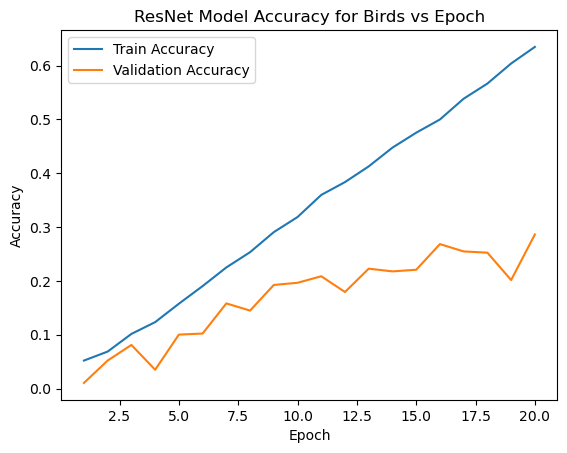

In [26]:
epochs = range(1, 21)
plt.plot(epochs, train_accuracy_resnet, label="Train Accuracy")
plt.plot(epochs, val_accuracy_resnet, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ResNet Model Accuracy for Birds vs Epoch")
plt.show()

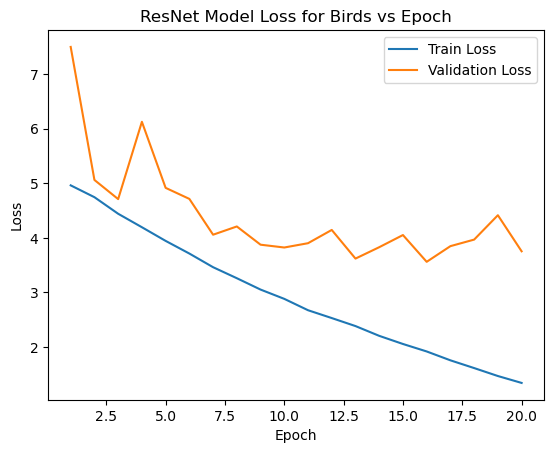

In [36]:
epochs = range(1, 21)
plt.plot(epochs, train_loss_resnet, label="Train Loss")
plt.plot(epochs, val_loss_resnet, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("ResNet Model Loss for Birds vs Epoch")
plt.show()

In [29]:
# Test data accuracy function modeled from CSE 446 PyTorch tutorial
def evaluate(
    model: nn.Module, loader: DataLoader
) -> Tuple[float, float]:
    """Computes test loss and accuracy of model on loader."""
    loss = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for (batch, labels) in loader:
            batch, labels = batch.to(device), labels.to(device)
            y_batch_pred = model(batch)
            batch_loss = loss(y_batch_pred, labels)
            test_loss = test_loss + batch_loss.item()

            pred_max = torch.argmax(y_batch_pred, 1)
            batch_acc = torch.sum(pred_max == labels)
            test_acc = test_acc + batch_acc.item()
        test_loss = test_loss / len(loader)
        test_acc = test_acc / (len(loader))
        return test_loss, test_acc

In [30]:
# Accuracy of Linear model with one hidden layer on test set
test_loss, test_acc = evaluate(resnet_model, data['test'])
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.2944074682340738


In [31]:
# From Transfer Learning Tutorial
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [35]:
predict(resnet_model, data['final_test'], "preds.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
